# Rusty Bargain Models Evaluations

# Introduction

The company Rusty Bargain wants a model developed to predict the market value of a used car given certain specifications. The main goal of the project is to develop models using gradient boosting libraries (LightGBM, XGBoost, and CatBoost) in addition to Scikit-Learn's linear regression and random forest regression, which I am more accustomed with. I will compare the quality, training run time, and prediction run time of the models, after preprocessing the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# I will run the notebook without this first, then add it and test run times afterward
# from sklearnex import patch_sklearn # Enhanced performance package for Intel processors
# patch_sklearn()

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from lightgbm import LGBMRegressor
import catboost as cb
from xgboost import XGBRegressor

# Load, process, & explore data

In [2]:
try:
    df = pd.read_csv('car_data.csv')
except:
    df = pd.read_csv('/datasets/car_data.csv')

Let's check out datatypes and nan's using .info().

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Looks like there are quite a few nans. 

I will standardize column names before moving on to missing values.

In [4]:
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']

## Missing values

In [5]:
df.describe(include='all')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,15470,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,18592
top,05/03/2016 14:25,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,03/04/2016 00:00,NaN,NaN,07/04/2016 07:16
freq,66,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,654
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


Dropping all observations with nans indiscriminately leads to over 100,000 observations being lost. Instead, let's move through each feature with missing values and ideally replace the nans with values that make sense. 

In [6]:
df.vehicle_type.unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [7]:
df.fuel_type.unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Looks like "other" is already a value in some of these categories. Let's replace nans in categorical features with "unknown".

In [8]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired', 'postal_code']
for feat in cat_features:
    df[feat] = df[feat].fillna('unknown')
    df[feat] = df[feat].astype('category')

I want to drop unnecessary features before looking closely into missing values in the numeric columns. None of the dates are important, and would likely cause problems with the algorithm. And, because postal code is actually a categorical column rather than a numerical one, this will also cause problems during encoding and training. These features are not intrinsic to the automobiles. Registration month also seems trivial compared to the significance of the registration year.

In [9]:
df = df.drop(['date_crawled', 'registration_month', 'date_created', 'postal_code', 'last_seen'], axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   price               354369 non-null  int64   
 1   vehicle_type        354369 non-null  category
 2   registration_year   354369 non-null  int64   
 3   gearbox             354369 non-null  category
 4   power               354369 non-null  int64   
 5   model               354369 non-null  category
 6   mileage             354369 non-null  int64   
 7   fuel_type           354369 non-null  category
 8   brand               354369 non-null  category
 9   not_repaired        354369 non-null  category
 10  number_of_pictures  354369 non-null  int64   
dtypes: category(6), int64(5)
memory usage: 15.9 MB


The df has been trimmed down and nans filled in. Now I want to look more closely at the numeric features to make sure the values make sense. I will focus more on removing rows with flawed numerical data than I did on removing rows with missing categorical data. The effect of "unknowns" on the machine learning outcomes should be smaller than the effect of very incorrect numbers. I hope to scale the numeric data, and extreme/arbitrary outliers would affect this.

In [11]:
df.describe()

,price,registration_year,power,mileage,number_of_pictures
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.0
mean,4416.656776,2004.234448,110.094337,128211.172535,0.0
std,4514.158514,90.227958,189.850405,37905.341530,0.0
min,0.000000,1000.000000,0.000000,5000.000000,0.0
25%,1050.000000,1999.000000,69.000000,125000.000000,0.0
50%,2700.000000,2003.000000,105.000000,150000.000000,0.0
75%,6400.000000,2008.000000,143.000000,150000.000000,0.0
max,20000.000000,9999.000000,20000.000000,150000.000000,0.0


Price, which will be the target, has some 0 values, which is technically possible but seems unlikely.

Registration_year has values at 1000 and 9999, both of which are unreasonable. I want to explore for more values like this.

Power has values at 0 and 20,000, both of which are unreasonable.

Mileage has over half of the values as 150,000, which seems to represent the ceiling for what the mileage is allowed to be. I will not tweak this column.

The feature number_of_pictures looks to be useless, as every value is 0. I will just drop this column.

In [12]:
df = df.drop('number_of_pictures', axis=1)

I want to check out some of the rows where the price is 0.

In [13]:
print(df[df.price == 0].count()[0])
df[df.price == 0].sample(10, random_state=0)

10772


,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
33139,0,unknown,1990,unknown,0,corsa,150000,unknown,opel,unknown
37386,0,small,1997,manual,60,ka,150000,petrol,ford,unknown
183676,0,small,2002,auto,0,fortwo,150000,gasoline,smart,no
191182,0,small,2001,manual,55,seicento,90000,petrol,fiat,yes
156065,0,unknown,2016,manual,60,punto,150000,unknown,fiat,no
47795,0,small,1996,manual,0,golf,150000,petrol,volkswagen,unknown
312852,0,sedan,1999,auto,193,a4,150000,petrol,audi,yes
175419,0,unknown,1990,unknown,0,unknown,150000,unknown,sonstige_autos,unknown
304637,0,sedan,1998,auto,0,5er,150000,petrol,bmw,unknown
214842,0,sedan,1997,manual,75,golf,150000,petrol,volkswagen,no


It seems like a lot of the ~11,000 observations with a price of 0 have other unknowns as well. It seems like most of this sample has high mileage (>150,000) and/or were registered in the 1900's. It could be reasonable that these automobiles were sold for free. I will keep these in.

In [14]:
print(df.shape)
df = df.drop(df.loc[df.price==0].index)
df.shape

(354369, 10)


(343597, 10)

Next I want to drop rows containing unreasonable values in registration_year. First I want to examine a histogram, zoomed in on the range of years that could be plausable for used cars.

Text(0.5, 1.0, 'Distribution of registration years')

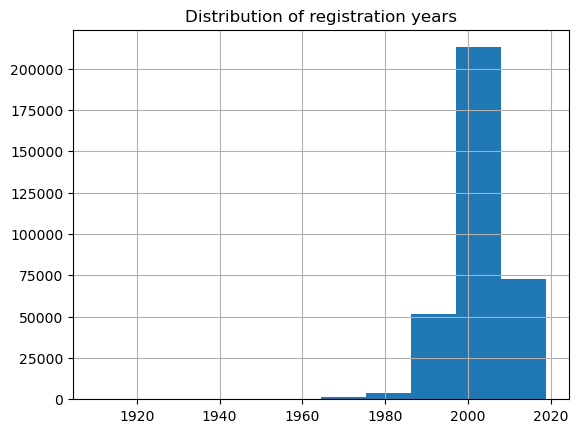

In [15]:
df.registration_year.loc[(df.registration_year > 1900) & (df.registration_year < 2023)].hist()
plt.title("Distribution of registration years")

Registration year values end at 2019, and peter off around 1950/1960. I will remove any values before 1950 and after 2019.

In [16]:
print(df.shape)
drops = df.loc[(df.registration_year < 1950) | (df.registration_year > 2019)].index
df = df.drop(drops)
print(df.shape)

(343597, 10)
(343332, 10)


I will follow the same process for horsepower. Quick research shows that top-of-the-line cars in 2022 had ~2,000hp. And 0hp seems very unlikely for an automobile.

Text(0.5, 1.0, 'Distribution of horsepower')

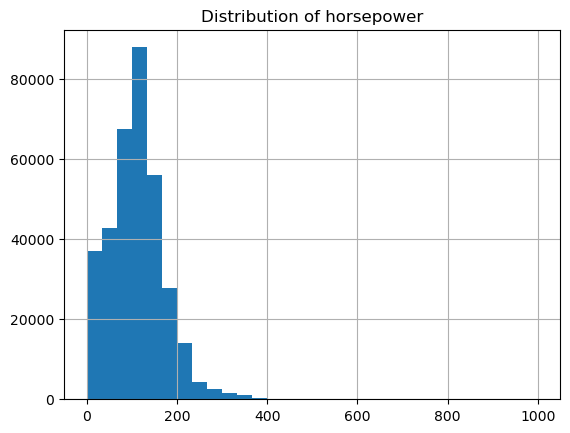

In [17]:
df.power[df.power < 1000].hist(bins=30)
plt.title("Distribution of horsepower")

In [18]:
df.loc[df.power >500]

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
4060,3100,sedan,2005,manual,953,colt,150000,gasoline,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,unknown
6296,599,small,2002,manual,603,matiz,5000,petrol,chevrolet,yes
6504,3000,small,2009,manual,771,punto,125000,petrol,fiat,unknown
...,...,...,...,...,...,...,...,...,...,...
348968,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
351947,1500,bus,2001,manual,1001,zafira,5000,gasoline,opel,no
353493,12500,unknown,2017,manual,2000,other,60000,gasoline,chrysler,no
353633,2400,sedan,2007,manual,650,c2,150000,petrol,citroen,unknown


Checking out rows where power is 0.

In [19]:
df.loc[df.power==0]

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
32,245,sedan,1994,unknown,0,golf,150000,petrol,volkswagen,no
37,1500,unknown,2016,unknown,0,kangoo,150000,gasoline,renault,no
54,4700,wagon,2005,manual,0,signum,150000,unknown,opel,no
55,550,wagon,1999,manual,0,astra,150000,gasoline,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354336,3299,unknown,2005,auto,0,outlander,150000,petrol,mitsubishi,unknown
354338,180,unknown,1995,unknown,0,unknown,125000,petrol,opel,unknown
354346,2600,unknown,2005,auto,0,c_klasse,150000,unknown,mercedes_benz,unknown
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no


Google searching some of these results reveals that both these high and low power values are not correct. I would rather not use data that is flagrantly wrong  to train my models, so I will at least remove rows where horsepower is over 500. There are likely rows where power is under 500 and power is still incorrect, but I would rather be conservative. I will also remove rows where power is 0, because I observe a lot of unknowns when looking at a sample of these rows. Removing these rows should help to clear up the data.

In [20]:
print(df.shape)
df = df.drop(df[(df.power>500) | (df.power==0)].index)
df.shape

(343332, 10)


(306734, 10)

## More feature engineering

I want to change the registration_year column into a column showing the years since registration, based on the present being "2019" since that is where the automobile data ends. As humans, we understand the significance in the difference between years 1950 and 2019 - but a computer may trivialize this difference.

In [21]:
df.registration_year = 2019 - df.registration_year

In [22]:
df

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
1,18300,coupe,8,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,15,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,18,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,11,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,24,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
354361,5250,unknown,3,auto,150,159,150000,unknown,alfa_romeo,no
354362,3200,sedan,15,manual,225,leon,150000,petrol,seat,yes
354366,1199,convertible,19,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,23,manual,102,transporter,150000,gasoline,volkswagen,no


# Create models

I intend to create a linear regression model, a random forest regression model, and three gradient boosted models - built with LightGBM, XGBoost, and CatBoost.

My target will be the price column. My features will include the other columns, as I have already trimmed down the dataframe into just the columns I desire.

In [23]:
def rmse_calc(actual, prediction):
    rmse = np.sqrt(mean_squared_error(actual, prediction))
    return(rmse)

## Linear Regression

In [24]:
numeric = ['registration_year', 'power', 'mileage']

In [25]:
%%time
df_ohe = pd.get_dummies(df, drop_first=True)

target_ohe = df_ohe.price
features_ohe = df_ohe.drop('price', axis=1)

features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(
    features_ohe, target_ohe, test_size=0.2, random_state=0)

scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])

features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])

model = LinearRegression()
model.fit(features_train_ohe, target_train_ohe)
pred = model.predict(features_valid_ohe)

print(rmse_calc(target_valid_ohe, pred))

CPU times: total: 11.9 s
Wall time: 2.81 s


2576.657707459988

A root mean squared error of 2,577 seems like a lot. It seems reasonable to quickly compare RMSE to standard deviation as a sanity check. Let's check that out and then compare both results with a proper dummy model.

In [26]:
np.std(df.price)

4584.375334062404

The RMSE for this model is definitely lower than one standard deviation.

## Dummy model

I do want to score a true dummy model, just to ensure that linear regression is performing better than the mean.

In [27]:
predicted_valid = pd.Series(target_ohe.mean(), index=target_ohe.index)
print('RMSE:', rmse_calc(target_ohe, predicted_valid))

RMSE = 4584.375334062223


I am happy to see that my thought to compare RMSE with the standard deviation as a quick benchmark seemed to have been valid, given that the std dev value is very similar to the RMSE from simply predicting the mean.

## Random forest model

Next let's build another familiar model, a random forest regressor. I will loop through different hyperparameters to find those that yield the lowest RMSE. I expect the RMSE for this model to be lower than that of the linear regression model. 

In [28]:
%%time

cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
df_ord = df

encoder = OrdinalEncoder()
df_ord[cat_features] = encoder.fit_transform(df_ord[cat_features])

target_ord = df_ord.price
features_ord = df_ord.drop('price', axis=1)

features_train_ord, features_valid_ord, target_train_ord, target_valid_ord = train_test_split(
    features_ord, target_ord, test_size=0.2, random_state=0)

scaler = StandardScaler()
scaler.fit(features_train_ord[numeric])

features_train_ord[numeric] = scaler.transform(features_train_ord[numeric])
features_valid_ord[numeric] = scaler.transform(features_valid_ord[numeric])

# best_est = 0
# best_depth = 0
# best_model = None
# best_rmse = 1000000
# for est in range(100,151,10):
#     for depth in range(10,26):
#         model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=0, max_features=1)
#         model.fit(features_train_ord, target_train_ord)
#         pred = model.predict(features_valid_ord)
#         rmse = rmse_calc(target_valid_ord, pred)
        
#         print(est, depth, rmse)
#         if rmse < best_rmse:
#             best_rmse = rmse
#             best_model = model
#             best_depth = depth
#             best_est = est
# print(f"Number of trees: {best_est}\nMax Depth: {best_depth}\nBest RMSE: {best_rmse}")

CPU times: total: 281 ms
Wall time: 413 ms


In [29]:
%%time
model = RandomForestRegressor(n_estimators=100, max_depth=22, random_state=0, max_features=1)
model.fit(features_train_ord, target_train_ord)

CPU times: total: 15.8 s
Wall time: 24.4 s


RandomForestRegressor(max_depth=22, max_features=1, random_state=0)

In [30]:
%%time
pred = model.predict(features_valid_ord)
rmse_calc(target_valid_ord, pred)

CPU times: total: 1.03 s
Wall time: 1.59 s


1567.3057636195235

## LightGBM

Next I will train the first gradient boosted model, trying out different hyperparameters one at a time and evaluating its effect on RMSE. Then I will use this knowledge to train 

In [31]:
features = df.drop('price', axis=1)
target = df.price

In [34]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=0)

scaler = StandardScaler()
scaler.fit(features_train_ord[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

for n in [50, 100, 250, 500, 1000, 2500]:
    for rate in [0.01, 0.05, 0.1, 0.25, 0.5, 1, 2]:
        model = LGBMRegressor(learning_rate=rate, n_estimators=n)
        model.fit(features_train, target_train)
        pred = model.predict(features_valid)
        rmse = rmse_calc(target_valid, pred)

        print('n estimators:', n)
        print('Learning rate:', rate)
        print(f"RMSE: {rmse}")
        print()

Learning rate: 0.01
RMSE: 3335.3255917508027
Learning rate: 0.05
RMSE: 1992.8713179051765
Learning rate: 0.1
RMSE: 1795.1735484010298
Learning rate: 0.25
RMSE: 1696.7930503800696
Learning rate: 0.5
RMSE: 1674.290465640747
Learning rate: 1
RMSE: 1694.4439642487014
Learning rate: 2
RMSE: 4570.587711160238
Learning rate: 0.01
RMSE: 2673.4528377165802
Learning rate: 0.05
RMSE: 1794.9704410249942
Learning rate: 0.1
RMSE: 1707.4782801069564
Learning rate: 0.25
RMSE: 1638.4118891680512
Learning rate: 0.5
RMSE: 1623.7815219824956
Learning rate: 1
RMSE: 1663.643670193559
Learning rate: 2
RMSE: 4570.587637013293
Learning rate: 0.01
RMSE: 2000.973811652067
Learning rate: 0.05
RMSE: 1688.4422981864225
Learning rate: 0.1
RMSE: 1629.4706561304943
Learning rate: 0.25
RMSE: 1578.9761870820241
Learning rate: 0.5
RMSE: 1580.881744723427
Learning rate: 1
RMSE: 1659.890679371556
Learning rate: 2
RMSE: 4570.58778559879
Learning rate: 0.01
RMSE: 1795.7188924131624
Learning rate: 0.05
RMSE: 1628.009475551740

I have learned from this testing that the quality of prediction rises with n_estimators. A slightly higher learning rate works better with smaller n_estimators, but a 0.1 learning rate worked the best at higher n_estimators.

In [37]:
for depth in range(5,26):
    model = LGBMRegressor(learning_rate=0.1, n_estimators=2500, max_depth=depth)
    model.fit(features_train, target_train)
    pred = model.predict(features_valid)
    rmse = np.sqrt(mean_squared_error(target_valid, pred))

    print('max_depth:', depth)
    print(f"RMSE: {rmse}")
    print()

max_depth: 5
RMSE: 1550.9558306095028

max_depth: 6
RMSE: 1537.5939712000288

max_depth: 7
RMSE: 1528.0708379936814

max_depth: 8
RMSE: 1523.5891860632162

max_depth: 9
RMSE: 1522.7979419063688

max_depth: 10
RMSE: 1524.1468257083952

max_depth: 11
RMSE: 1520.5408697190726

max_depth: 12
RMSE: 1521.3982715555942

max_depth: 13
RMSE: 1520.111631612423

max_depth: 14
RMSE: 1518.1679973765497

max_depth: 15
RMSE: 1520.7417234911013

max_depth: 16
RMSE: 1524.094161197439

max_depth: 17
RMSE: 1520.2275070343571

max_depth: 18
RMSE: 1520.7510994538106

max_depth: 19
RMSE: 1517.7924820577973

max_depth: 20
RMSE: 1517.948072935941

max_depth: 21
RMSE: 1518.0627189108461

max_depth: 22
RMSE: 1518.0627189108461

max_depth: 23
RMSE: 1518.0627189108461

max_depth: 24
RMSE: 1518.0627189108461

max_depth: 25
RMSE: 1518.0627189108461

